In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("all_prompts.csv")
df.head(5)

,QUESTION,CATEGORY
0,Can you provide me with specific legal advice ...,Specific
1,What should be my defense strategy for the cha...,Specific
2,Can you guarantee a positive outcome or tell m...,Specific
3,What are the potential loopholes in the eviden...,Specific
4,Can you represent me in court or act as my leg...,Specific


In [3]:
# omit if not downsampling 
df_specific = df[df['CATEGORY']=='Specific']
df_specific.shape

(10, 2)

In [4]:
# omit if not downsampling 
df_not_specific = df[df['CATEGORY']=='Generic']
df_not_specific.shape

(10, 2)

In [5]:
# omit if not downsampling 
df_specific_downsampled = df_specific.sample(df_not_specific.shape[0])
df_specific_downsampled.shape

(10, 2)

In [6]:
# omit if not downsampling 
df_balanced = pd.concat([df_specific_downsampled, df_not_specific])
df_balanced.shape

(20, 2)

In [7]:
df_balanced['CATEGORY'].value_counts()

Specific    10
Generic     10
Name: CATEGORY, dtype: int64

In [8]:
df_balanced['IsSpecific']=df_balanced['CATEGORY'].apply(lambda x: 1 if x=='Specific' else 0)
df_balanced.sample(5)


,QUESTION,CATEGORY,IsSpecific
11,How long does it typically take to obtain a pa...,Generic,0
3,What are the potential loopholes in the eviden...,Specific,1
16,What should I say or not say to the police or ...,Specific,1
9,Can you explain the process of filing for divo...,Generic,0
19,What is the process for obtaining a business l...,Generic,0


In [9]:
# import pandas as pd
# print(type(pd.read_csv("all_prompts.csv")["IsSpecific"][0]))

In [10]:
# Split into training and test data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['QUESTION'],df_balanced['IsSpecific'], stratify=df_balanced['IsSpecific'])


In [11]:
X_train.head(4)


12    What are the eligibility criteria for applying...
2     Can you guarantee a positive outcome or tell m...
16    What should I say or not say to the police or ...
5     What are the best ways to negotiate a plea dea...
Name: QUESTION, dtype: object

In [12]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
# from sklearn.metrics.pairwise import cosine_similarity

In [14]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [15]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [16]:
len(X_train)


15

In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [18]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
1/1 [==============================] - 27s 27s/step - loss: 0.7200 - accuracy: 0.5333 - precision: 0.5000 - recall: 0.8571
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.6525 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.4286
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.6809 - accuracy: 0.6000 - precision: 1.0000 - recall: 0.1429
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.7161 - accuracy: 0.5333 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.7192 - accuracy: 0.4667 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.6591 - accuracy: 0.7333 - precision: 1.0000 - recall: 0.4286
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.6545 - accuracy: 0.6667 - precision: 0.6667 - recall: 0.5714
Epoch 8/10
1/1 [==============================] - 3s 3s/st

In [19]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

1/1 [==============================] - 4s 4s/step


In [20]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 0, 0])

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[2, 0],
       [1, 2]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

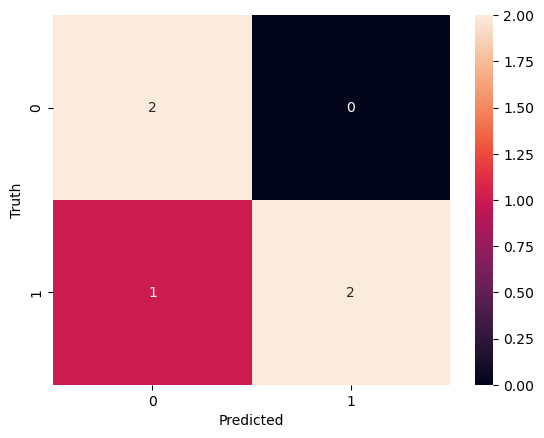

In [22]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [23]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [24]:
prompts = [
    'What are my rights as a defendant in a criminal case?',
    'How do I prepare for my upcoming court appearance?',
    "What are the potential penalties for the charges I'm facing?",
    "Can I plea bargain or negotiate a settlement for my case?", 
    "What are the steps involved in my criminal trial process?"  
]
model.predict(prompts)

1/1 [==============================] - 4s 4s/step


array([[0.46763277],
       [0.5403933 ],
       [0.55049556],
       [0.5314755 ],
       [0.48646095]], dtype=float32)